In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

import torchvision as tv

import numpy as np

import typing as tp
import os

import cv2

import matplotlib.pyplot as plt
import math
import itertools

from editdistance import eval as edit_distance

from tqdm import tqdm

import errno

from ml_collections import ConfigDict

import importlib
import wandb

In [4]:
import diploma_code

from diploma_code.model import (
    ConvBlock, FusedInvertedBottleneck, ReduceBlock, Backbone, PositionalEncoding,
    TransformerEncoder, CTCRawDecoder, CTCDecoderModel, ParallelModel, make_single_model, make_model
)
from diploma_code.data_loader.transforms import (
    HorizontalChunker, VerticalRandomMasking, HorizontalResizeOnly, ChunkTransform, GaussianNoise, 
    RandomHorizontalStretch, RandomChoiceN
)
from diploma_code.data_loader.data_common import (
    Sample, CharEncoder
)
from diploma_code.data_loader.iam import (
    load_iam_data_dict, make_iam_split
)
from diploma_code.data_loader.mjsynth import (
    load_mjsynth_chars, load_mjsynth_samples
)
from diploma_code.data_loader.datasets import (
    BaseLTRDataset, LongLinesLTRDataset, MyConcatDataset, MergingSampler, TransformLTRWrapperDataset
)
from diploma_code.data_loader.loader import (
    stacking_collate_fn
)
from diploma_code.make_loader import (
    make_dataloader, make_char_encoder
)
from diploma_code.optimizing import (
    pytorch_make_optimizer, StepLRWithWarmup, make_lr_scheduler
)
from diploma_code.utils import (
    log_metric_wandb, batch_to_device
)
from diploma_code.evaluation import (
    my_ctc_loss, my_dml_loss, decode_ocr_probs, decode_targets, get_edit_distance, 
    EpochValueProcessor, EpochDMLProcessor, CERProcessor
)
from diploma_code.trainer import (
    LTRTrainer
)

from diploma_code.config import default_diploma_config, get_config

In [33]:
m = tv.models.resnet34(weights=tv.models.ResNet34_Weights.DEFAULT)
input_conv = nn.Conv2d(3, 64, 7, 1, 3)
blocks = [input_conv, m.bn1, m.relu,
          m.maxpool, m.layer1, m.layer2, m.layer3]
model = nn.Sequential(*blocks)
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, 

In [35]:
model.forward(torch.zeros(4,3,64,1024)).shape

torch.Size([4, 256, 8, 128])

In [5]:
importlib.reload(diploma_code.data_loader)
importlib.reload(diploma_code.data_loader.datasets)
importlib.reload(diploma_code.data_loader.data_common)
importlib.reload(diploma_code.data_loader.transforms)
importlib.reload(diploma_code.data_loader.iam)
importlib.reload(diploma_code.data_loader.mjsynth)
importlib.reload(diploma_code.data_loader.loader)
importlib.reload(diploma_code.optimizing)
importlib.reload(diploma_code.make_loader)
importlib.reload(diploma_code.make_transforms)
importlib.reload(diploma_code.config)
importlib.reload(diploma_code.model)
importlib.reload(diploma_code.utils)
importlib.reload(diploma_code.evaluation)
importlib.reload(diploma_code.trainer)



<module 'diploma_code.trainer' from '/home/lehahel/dmdiploma/diploma_code/trainer.py'>

In [6]:
wandb.login()

wandb: Currently logged in as: kafka_zhuk. Use `wandb login --relogin` to force relogin


True

In [201]:
!python3 ./train.py  --config=./diploma_code/config.py --config.wandb.run_name='sad_dogo'

/bin/bash: /home/lehahel/dmdiploma/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
wandb: Currently logged in as: kafka_zhuk. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.2
wandb: Run data is saved locally in /home/lehahel/dmdiploma/wandb/run-20230510_025237-9e12ca54
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sad_dogo
wandb: ⭐️ View project at https://wandb.ai/kafka_zhuk/diploma_dml
wandb: 🚀 View run at https://wandb.ai/kafka_zhuk/diploma_dml/runs/9e12ca54
Traceback (most recent call last):
  File "/home/lehahel/dmdiploma/./train.py", line 23, in <module>
    app.run(main)
  File "/home/lehahel/dmdiploma/miniconda3/lib/python3.10/site-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/home/lehahel/dmdiploma/miniconda3/lib/python3.10/site-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/home/lehahel/dmdiploma/./train.py", line 

In [14]:
diploma_code.config.CHUNK_SIZE = 640
cfg = get_config()
cfg.training.eval_epochs_interval = 1
cfg.training.eval_test_interval = 3
cfg.training.snapshot_epochs_interval = 3
cfg.data.root_path = './data'
cfg.data.iam.path = './data/iam'
cfg.data.mjsynth.path = './data/mjsynth/mnt/ramdisk/max/mjsynth'

cfg.optimizer.lr = 3e-4
cfg.optimizer.weight_decay=1e-5

# cfg.training.load_from_checkpoint = True
# cfg.wandb.resume = True

In [15]:
cfg

data:
  chunk_size: 640
  iam:
    path: ./data/iam
    train_len: !!python/object:ml_collections.config_dict.config_dict.FieldReference
      _field_type: &id001 !!python/name:builtins.int ''
      _ops: []
      _required: false
      _value: 6482
    transforms:
      distortion_scale: 0.1
      gauss_kernel_size: !!python/tuple
      - 5
      - 5
      gauss_sigma: !!python/tuple
      - 1.0
      - 2.5
      image_height: &id002 !!python/object:ml_collections.config_dict.config_dict.FieldReference
        _field_type: *id001
        _ops: []
        _required: false
        _value: 40
      inverse_prob: 0.5
      noise_gauss: !!python/tuple
      - 0.02
      - 0.1
      number_of_transforms: 3
      stretch_factor: !!python/tuple
      - 0.8
      - 1.2
      vertical_mask_max_height_ratio: 0.5
      vertical_mask_min_height_ratio: 0.25
      vertical_mask_tile_prob: 0.15
    weight: !!python/object:ml_collections.config_dict.config_dict.FieldReference
      _field_type: *id001

In [16]:
ltr = LTRTrainer(cfg)

In [17]:
ltr.configure_loader("train")

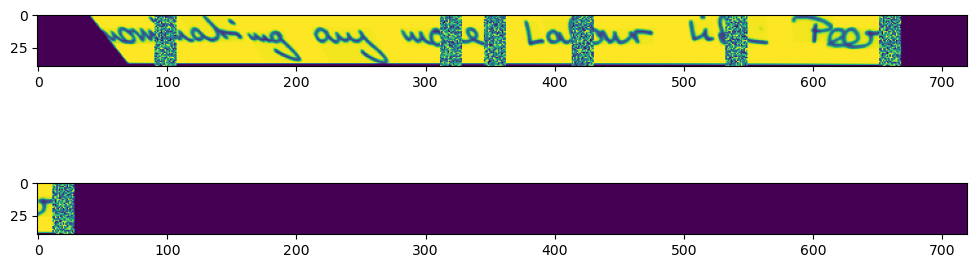

In [21]:


def show_chunks(t: torch.Tensor) -> None:
    b = t.shape[0]
    fig, axes = plt.subplots(figsize=(12, 2 * b), nrows=b, ncols=1)
    if isinstance(axes, plt.Axes):
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.imshow(t[i, :, :, :].squeeze(0))
    
    
show_chunks(ltr.train_loader.dataset[1]['input'])

In [22]:
ltr.train('sad_dogo')

  4%|██▊                                                                             | 114/3241 [00:07<03:30, 14.84it/s]


KeyboardInterrupt: 

In [246]:
path = "data/mjsynth/mnt/ramdisk/max/90kDICT32px"

bad_files = []

import time

count = 0
begin = time.time()

for dirpath, dirnames, filenames in os.walk(path):
    for filename in filenames:
        if filename.split('.')[-1] == 'jpg':
            full_path = os.path.join(dirpath, filename)
            with open(full_path, 'rb') as im:
                try:
                    im.seek(-2,2)
                except OSError as e:
                    print(f'failed to process file {full_path}, error: {e}')
                    bad_files.append(full_path)
                    continue
                if im.read() != b'\xff\xd9':
                    print(f'{full_path} has premature end of jpeg file')
                    bad_files.append(full_path)
                    continue
            val = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            if val is None:
                print(f'{full_path} has a corrupted image')
                bad_files.append(full_path)
            count += 1
            if count % 100000 == 0:
                print(f'Checked {count} images in {time.time() - begin} seconds, found {len(bad_files)} corrupted')
    

data/mjsynth/mnt/ramdisk/max/90kDICT32px/1696/4/211_Queened_61779.jpg has premature end of jpeg file
Checked 100000 images in 18.951529502868652 seconds, found 1 corrupted
data/mjsynth/mnt/ramdisk/max/90kDICT32px/2540/4/246_SQUAMOUS_73902.jpg has premature end of jpeg file
Checked 200000 images in 37.68372654914856 seconds, found 2 corrupted
Checked 300000 images in 56.298471212387085 seconds, found 2 corrupted
Checked 400000 images in 75.03809976577759 seconds, found 2 corrupted
Checked 500000 images in 93.85237288475037 seconds, found 2 corrupted
data/mjsynth/mnt/ramdisk/max/90kDICT32px/2489/4/221_snored_72290.jpg has premature end of jpeg file
Checked 600000 images in 112.51990985870361 seconds, found 3 corrupted
Checked 700000 images in 131.21052145957947 seconds, found 3 corrupted
Checked 800000 images in 150.05990934371948 seconds, found 3 corrupted
Checked 900000 images in 168.71192383766174 seconds, found 3 corrupted
Checked 1000000 images in 187.46954560279846 seconds, found 3

Checked 7500000 images in 1446.9203684329987 seconds, found 27 corrupted
failed to process file data/mjsynth/mnt/ramdisk/max/90kDICT32px/913/4/231_randoms_62372.jpg, error: [Errno 22] Invalid argument
Checked 7600000 images in 1466.345933675766 seconds, found 28 corrupted
Checked 7700000 images in 1485.691297531128 seconds, found 28 corrupted
Checked 7800000 images in 1504.955777645111 seconds, found 28 corrupted
Checked 7900000 images in 1524.2437522411346 seconds, found 28 corrupted
data/mjsynth/mnt/ramdisk/max/90kDICT32px/384/4/220_bolts_8596.jpg has premature end of jpeg file
failed to process file data/mjsynth/mnt/ramdisk/max/90kDICT32px/1817/2/363_actuating_904.jpg, error: [Errno 22] Invalid argument
Checked 8000000 images in 1543.4584033489227 seconds, found 30 corrupted
Checked 8100000 images in 1562.727600812912 seconds, found 30 corrupted
data/mjsynth/mnt/ramdisk/max/90kDICT32px/905/4/234_Postscripts_59142.jpg has premature end of jpeg file
Checked 8200000 images in 1582.0282